In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from tqdm import tqdm
from sklearn.datasets import load_files
from pyvi import ViTokenizer
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
%matplotlib inline

In [5]:
data = np.genfromtxt('german.data-numeric')
X_data = data[:,:24]
Y_data = data[:,-1]
print(X_data.shape)
print(Y_data.shape)

(1000, 24)
(1000,)


In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size = 0.2, random_state = 42)

In [7]:
# Hàm tính neg_cost, dùng để truyền vào scoring của learning_curve
from sklearn.metrics import make_scorer
def neg_cost(estimator, X, y):
    y_true = y
    y_pred = estimator.predict(X)
    true_pos = ((y_true == y_pred) & (y_true == 1.0)) * 0.0
    true_ne = ((y_true == y_pred) & (y_true == 2.0)) * 0.0
    false_ne = ((y_true != y_pred) & (y_true == 1.0)) * 1.0
    false_pos = ((y_true != y_pred) & (y_true == 2.0)) * 5.0
    return -sum(true_pos + true_ne + false_pos + false_ne)/len(y_true)

In [8]:
def cross_validation(estimator):
    _, train_scores, test_scores = learning_curve(estimator, X_train, Y_train, cv = 10, n_jobs = -1, train_sizes = [1.0, ], scoring = neg_cost)
    test_scores = test_scores[0]
    mean, std = test_scores.mean(), test_scores.std()
    return mean, std

def plot(title, xlabel, X, Y, error, ylabel = "Negative Cost"):
    plt.xlabel(xlabel)
    plt.title(title)
    plt.grid()
    plt.ylabel(ylabel)
    plt.errorbar(X, Y, error, linestyle = 'None', marker = 'o')

## I. SVM Params

1. kernel Param

100%|██████████| 4/4 [00:03<00:00,  1.12it/s]


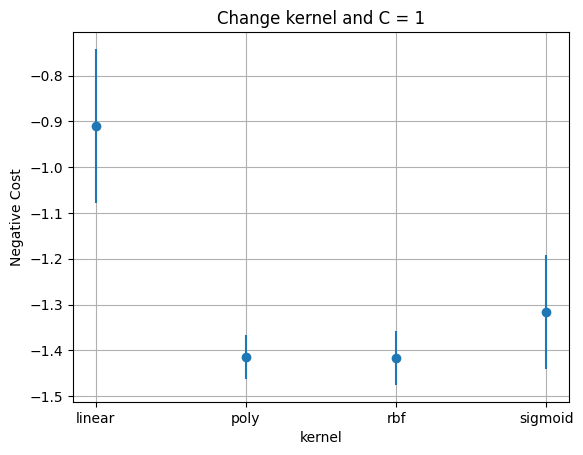

In [9]:
title = "Change kernel and C = 1"
xlabel = "kernel"
X = []
Y = []
error = []
for kernel in tqdm(['linear', 'poly', 'rbf', 'sigmoid']):
    # Với mỗi kernel được chọn,
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = svm.SVC(kernel = kernel, C = 1.0)
    mean, std = cross_validation(text_clf)
    X.append(kernel)
    Y.append(mean)
    error.append(std)
    
plot(title, xlabel, X, Y, error)
plt.show()

2. C param

100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


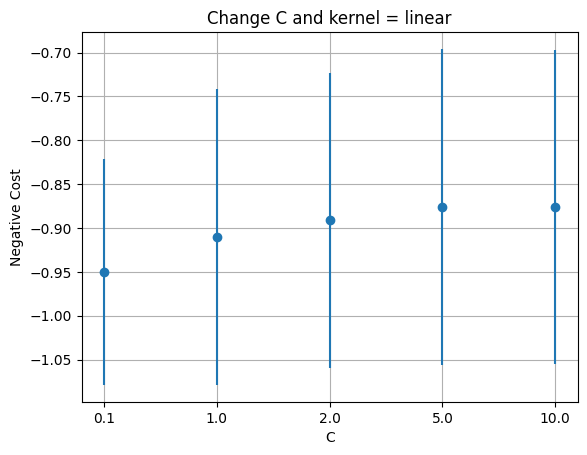

In [10]:
title = "Change C and kernel = linear"
xlabel = "C"
X = []
Y = []
error = []
for C in tqdm([.1, 1.0, 2.0, 5.0, 10.0]):
    text_clf = svm.SVC(kernel = 'linear', C = C)
    mean, std = cross_validation(text_clf)
    X.append(str(C))
    Y.append(mean)
    error.append(std)
    
plot(title, xlabel, X, Y, error)
plt.show()

## II. Random Forest Params

1. Criterion Param

100%|██████████| 2/2 [00:00<00:00,  4.86it/s]


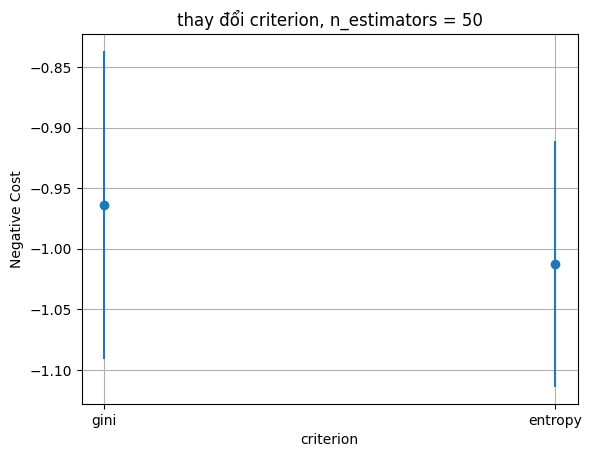

In [11]:
title = "thay đổi criterion, n_estimators = 50"
xlabel = "criterion"
X = []
Y = []
error = []

for criterion in tqdm(["gini", "entropy"]):
    # Với mỗi criterion nhận được,
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = RandomForestClassifier(criterion = criterion, n_estimators=50)
    mean, std = cross_validation(text_clf)
    X.append(str(criterion))
    Y.append(mean)
    error.append(std)

# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
plt.show()


2. n_estimators Param

100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


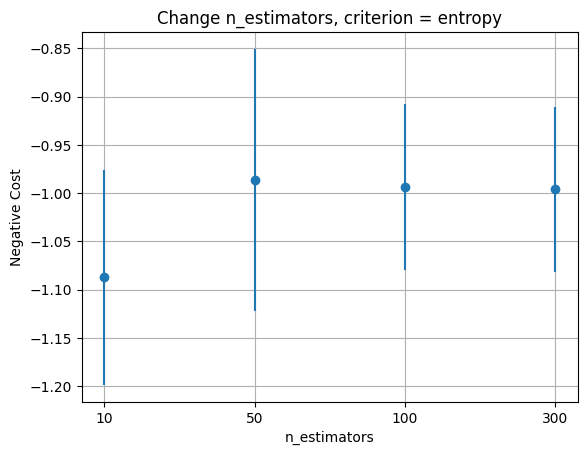

In [12]:
title = "Change n_estimators, criterion = entropy"
xlabel = "n_estimators"
X = []
Y = []
error = []

for n_estimators in tqdm([10, 50, 100, 300]):
    text_clf = RandomForestClassifier(criterion = 'entropy', n_estimators = n_estimators)
    mean, std = cross_validation(text_clf)
    X.append(str(n_estimators))
    Y.append(mean)
    error.append(std)

plot(title, xlabel, X, Y, error)
plt.show()

## KNN

1. k Param

100%|██████████| 5/5 [00:00<00:00, 30.21it/s]


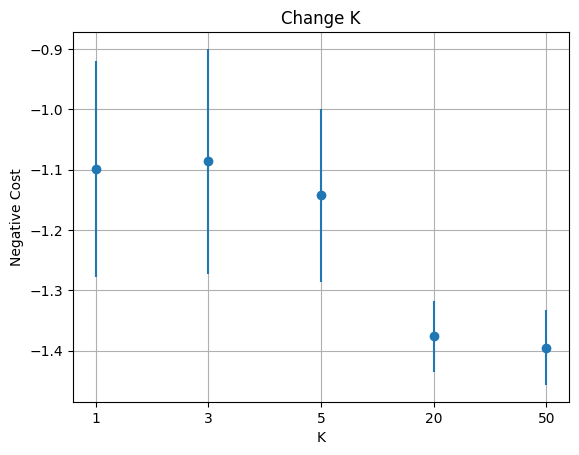

In [13]:
title = "Change K"
xlabel = "K"
X = []
Y = []
error = []

for k in tqdm([1, 3, 5, 20, 50]):
    text_clf = KNeighborsClassifier(n_neighbors = k)
    mean, std = cross_validation(text_clf)
    X.append(str(k))
    Y.append(mean)
    error.append(std)

plot(title, xlabel, X, Y, error)
plt.show()


## Models Comparartion

In [18]:
svm_ = svm.SVC(kernel = 'linear', C = 10)
rf = RandomForestClassifier(criterion = 'entropy', n_estimators = 50)
knn = KNeighborsClassifier(n_neighbors = 3)

svm_.fit(X_train, Y_train)
rf.fit(X_train, Y_train)
knn.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=3)

In [19]:
print(f'SVM: {neg_cost(svm_, X_test, Y_test)}')
print(f'RF: {neg_cost(rf, X_test, Y_test)}')
print(f'KNN: {neg_cost(knn, X_test, Y_test)}')

SVM: -0.88
RF: -0.985
KNN: -1.16
